# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">🩺 SenNet + HOA - Hacking the Human Vasculature in 3D</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Clean Code 📚| Weighted Ensemble </center></p>
***

<i>
This is a Clean Code inference notebook for Kaggle's SenNet + HOA Competition. <span style='color:#FFCE30'> 
</i>

This Notebook is based on Misaki's [Notebook](https://www.kaggle.com/code/misakimatsutomo/inference-1024-should-have-a-percentile-of-0-00149) and Ada Luo Dao's [Notebook](https://www.kaggle.com/code/adaluodao/inference-1024-ensemble-512-1024).

<div style="font-family: Cambria; background-color:#e0ffcd; color:#19180F; font-size:19px;  padding:10px; border: 2px solid #19180F; border-radius:10px"> 
    <h4>If you find my Kaggle notebook helpful, please consider giving it an <span style='color:#005792'><b>upvote!</b></span>👍</h4>
</div>

## Training Codes of this inference

First model: https://www.kaggle.com/nguynvnthtr/the-training-image-is-1024-x-1024
Version 1

Second model: https://www.kaggle.com/code/lispprolog/training-512-kidney-1-and-3/notebook Version 9

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Import Libraries</div> 

In [1]:
# Importing PyTorch library 
import torch as tc 
# Importing neural network module from PyTorch
import torch.nn as nn
# Importing automatic mixed precision (AMP) for faster training on GPU
from torch.cuda.amp import autocast
# Importing Dataset and DataLoader classes for handling data in PyTorch
from torch.utils.data import Dataset, DataLoader
# Importing DataParallel for parallel processing in PyTorch
from torch.nn.parallel import DataParallel


# Importing NumPy 
import numpy as np
# Importing tqdm for displaying progress bars
from tqdm import tqdm

# Importing OpenCV library
import cv2
# Importing os and sys modules for interacting with the operating system
import os
import sys
# Importing the glob module for searching directories with wildcard patterns
from glob import glob
# Importing matplotlib 
import matplotlib.pyplot as plt
# Importing pandas 
import pandas as pd

# Installing segmentation Models
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch -q
# Importing the segmentation_models_pytorch library 
import segmentation_models_pytorch as smp

# Importing load_dotenv for loading environment variables
from dotenv import load_dotenv

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Config</div> 

In [2]:
# Defining variables to specify model paths
model_path_i = 0  
model_path_i9 = 1

# Configuration class containing various model and training parameters
class CFG:
    # Model configuration
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 1
    image_size = 1024
    input_size = 1024
    tile_size = image_size
    stride = tile_size // 4
    drop_egde_pixel = 0
    target_size = 1
    chopping_percentile = 1e-3

    # Fold and validation configuration
    valid_id = 1
    batch = 16
    th_percentile = 0.0014
    axis_w = [0.328800989, 0.336629584, 0.334569427]
    axis_second_model = 0

    # Model paths for different folds
    model_path = [
        "/kaggle/input/sennet-new-ckpts/512_model_after_DataLoader_kidney_3_dense.pth_epoch_24.pt",  ## 512
        "/kaggle/input/sennet-new-ckpts/768_model_after_DataLoader_kidney_3_dense.pth_epoch_24.pt"  ## 768
    ]

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Model </div> 

In [3]:
# Custom model class definition
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        
        # Storing configuration parameters within the model
        self.CFG = CFG
        
        # Creating an instance of the Unet model from segmentation_models_pytorch
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        
        # Setting batch size from the configuration
        self.batch = CFG.batch

    def forward_(self, image):
        # Forward pass through the model
        output = self.model(image)
        # Extracting the first channel from the output
        return output[:, 0]

    def forward(self, x: tc.Tensor):
        # Converting input tensor to float32
        x = x.to(tc.float32)
        
        # Normalizing the input tensor using a custom function 'norm_with_clip'
        x = norm_with_clip(x.reshape(-1, *x.shape[2:])).reshape(x.shape)
        
        # Interpolating the input tensor if input size is not equal to image size
        if CFG.input_size != CFG.image_size:
            x = nn.functional.interpolate(x, size=(CFG.input_size, CFG.input_size), mode='bilinear', align_corners=True)
        
        # Performing data augmentation by rotating the input tensor
        shape = x.shape
        x = [tc.rot90(x, k=i, dims=(-2, -1)) for i in range(4)]
        x = tc.cat(x, dim=0)
        
        # Using autocast for mixed precision training and no_grad to disable gradient computation
        with autocast():
            with tc.no_grad():
                # Forward pass for each rotated batch
                x = [self.forward_(x[i * self.batch:(i + 1) * self.batch]) for i in range(x.shape[0] // self.batch + 1)]
                # Concatenating the results along the batch dimension
                x = tc.cat(x, dim=0)
        
        # Applying sigmoid activation and reshaping the tensor
        x = x.sigmoid()
        x = x.reshape(4, shape[0], *shape[2:])
        
        # Rotating the tensor back to the original orientation
        x = [tc.rot90(x[i], k=-i, dims=(-2, -1)) for i in range(4)]
        # Stacking along a new dimension and taking the mean
        x = tc.stack(x, dim=0).mean(0)
        
        # Interpolating the output tensor if input size is not equal to image size
        if CFG.input_size != CFG.image_size:
            x = nn.functional.interpolate(x[None], size=(CFG.image_size, CFG.image_size), mode='bilinear', align_corners=True)[0]
        
        return x

# Function to build the model
def build_model(weight=None):
    # Loading environment variables using dotenv
    load_dotenv()

    # Printing model name and backbone information
    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    # Creating an instance of the CustomModel with specified weight
    model = CustomModel(CFG, weight)

    # Moving the model to the GPU
    return model.cuda()

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Image Size </div> 

In [4]:
# Function to resize image to 1024x1024 with rotation
def to_1024(img, image_size=1024):
    if image_size > img.shape[1]:
        # Rotate image 90 degrees
        img = np.rot90(img)
        
        # Calculate padding for top and bottom
        start1 = (CFG.image_size - img.shape[0]) // 2
        top = img[0: start1, 0: img.shape[1]]
        bottom = img[img.shape[0] - start1: img.shape[0], 0: img.shape[1]]
        
        # Concatenate top, rotated image, and bottom
        img_result = np.concatenate((top, img, bottom), axis=0)
        
        # Rotate image back to the original orientation
        img_result = np.rot90(img_result)
        img_result = np.rot90(img_result)
        img_result = np.rot90(img_result)
    else:
        img_result = img
    
    return img_result

# Function to resize image to 1024x1024 without rotation
def to_1024_no_rot(img, image_size=1024):
    if image_size > img.shape[0]:
        # Calculate padding for top and bottom
        start1 = (image_size - img.shape[0]) // 2
        top = img[0: start1, 0: img.shape[1]]
        bottom = img[img.shape[0] - start1: img.shape[0], 0: img.shape[1]]
        
        # Concatenate top, image, and bottom
        img_result = np.concatenate((top, img, bottom), axis=0)
    else:
        img_result = img
    
    return img_result

# Function to resize image to 1024x1024 using to_1024 function
def to_1024_1024(img, image_size=1024):
    img_result = to_1024(img, image_size)
    return img_result

# Function to resize image back to original size
def to_original(im_after, img, image_size=1024):
    top_ = 0
    left_ = 0
    
    # Calculate padding for top
    if im_after.shape[0] > img.shape[0]:
        top_ = (image_size - img.shape[0]) // 2
    
    # Calculate padding for left
    if im_after.shape[1] > img.shape[1]:
        left_ = (image_size - img.shape[1]) // 2
    
    # Extract the region of interest from the resized image
    if (top_ > 0) or (left_ > 0):
        img_result = im_after[top_: img.shape[0] + top_, left_: img.shape[1] + left_]
    else:
        img_result = im_after
    
    return img_result

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Helper Functions </div> 

In [5]:
# Function to encode a binary mask using Run-Length Encoding (RLE)
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

# Function for min-max normalization of a PyTorch tensor
def min_max_normalization(x: tc.Tensor) -> tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape = x.shape
    if x.ndim > 2:
        x = x.reshape(x.shape[0], -1)

    min_ = x.min(dim=-1, keepdim=True)[0]
    max_ = x.max(dim=-1, keepdim=True)[0]
    if min_.mean() == 0 and max_.mean() == 1:
        return x.reshape(shape)

    x = (x - min_) / (max_ - min_ + 1e-9)
    return x.reshape(shape)

# Function for normalization with clipping of a PyTorch tensor
def norm_with_clip(x: tc.Tensor, smooth=1e-5):
    dim = list(range(1, x.ndim))
    mean = x.mean(dim=dim, keepdim=True)
    std = x.std(dim=dim, keepdim=True)
    x = (x - mean) / (std + smooth)
    x[x > 5] = (x[x > 5] - 5) * 1e-3 + 5
    x[x < -3] = (x[x < -3] + 3) * 1e-3 - 3
    return x

# Function to add an edge to an image tensor
def add_edge(x: tc.Tensor, edge: int):
    # x=(C,H,W)
    # output=(C,H+2*edge,W+2*edge)
    mean_ = int(x.to(tc.float32).mean())
    x = tc.cat([x, tc.ones([x.shape[0], edge, x.shape[2]], dtype=x.dtype, device=x.device) * mean_], dim=1)
    x = tc.cat([x, tc.ones([x.shape[0], x.shape[1], edge], dtype=x.dtype, device=x.device) * mean_], dim=2)
    x = tc.cat([tc.ones([x.shape[0], edge, x.shape[2]], dtype=x.dtype, device=x.device) * mean_, x], dim=1)
    x = tc.cat([tc.ones([x.shape[0], x.shape[1], edge], dtype=x.dtype, device=x.device) * mean_, x], dim=2)
    return x


<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Data Loader </div> 

In [6]:
# Dataset class for loading images
class Data_loader(Dataset):
    def __init__(self, path, s="/images/"):
        self.paths = glob(path + f"{s}*.tif")
        self.paths.sort()
        self.bool = s == "/labels/"

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = cv2.imread(self.paths[index], cv2.IMREAD_GRAYSCALE)
        img = to_1024_1024(img, image_size=CFG.image_size)

        img = tc.from_numpy(img.copy())
        if self.bool:
            img = img.to(tc.bool)
        else:
            img = img.to(tc.uint8)
        return img

# Function to load data using Data_loader and perform normalization
def load_data(path, s):
    data_loader = Data_loader(path, s)
    data_loader = DataLoader(data_loader, batch_size=16, num_workers=2)
    data = []
    for x in tqdm(data_loader):
        data.append(x)
    x = tc.cat(data, dim=0)
    
    # Chopping values above and below a certain percentile
    TH = x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH: int = np.partition(TH, index)[index]
    x[x > TH] = int(TH)
    
    TH = x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH: int = np.partition(TH, -index)[-index]
    x[x < TH] = int(TH)
    
    x=(min_max_normalization(x.to(tc.float16)[None])[0]*255).to(tc.uint8)
    
    return x

# Dataset class for pipeline processing
class Pipeline_Dataset(Dataset):
    def __init__(self, x, path):
        self.img_paths = glob(path + "/images/*")
        self.img_paths.sort()
        self.in_chan = CFG.in_chans
        z = tc.zeros(self.in_chan // 2, *x.shape[1:], dtype=x.dtype)
        self.x = tc.cat((z, x, z), dim=0)

    def __len__(self):
        return self.x.shape[0] - self.in_chan + 1

    def __getitem__(self, index):
        x = self.x[index:index + self.in_chan]
        return x, index

    def get_mark(self, index):
        id = self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id = "_".join(id)
        return id[:-4]

    def get_marks(self):
        ids = []
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Buiding Models </div> 

In [7]:
# Building and loading the 1024 x 1024 Image Model
model = build_model()  # Creating an instance of the model
model.load_state_dict(tc.load(CFG.model_path[model_path_i], "cpu"))  # Loading the pre-trained weights
model.eval()  # Setting the model to evaluation mode
model = DataParallel(model)  # Using DataParallel for parallel processing

# Building and loading the 512 x 512 Image Model
model9 = build_model()  # Creating an instance of the model
model9.load_state_dict(tc.load(CFG.model_path[model_path_i9], "cpu"))  # Loading the pre-trained weights
model9.eval()  # Setting the model to evaluation mode
model9 = DataParallel(model9)  # Using DataParallel for parallel processing


model_name Unet
backbone se_resnext50_32x4d
model_name Unet
backbone se_resnext50_32x4d


<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Prediction & Weighted Ensemble </div> 

In [8]:
# Function to get segmentation outputs
def get_output(debug=False):
    outputs = []

    # Specify paths for testing
    if debug:
        paths = ["/kaggle/input/blood-vessel-segmentation/train/kidney_2"]
    else:
        paths = glob("/kaggle/input/blood-vessel-segmentation/test/*")

    outputs = [[], []]

    # Loop through each path
    for path in paths:
        # Load data and initialize labels
        x = load_data(path, "/images/")
        labels = tc.zeros_like(x, dtype=tc.uint8)
        mark = Pipeline_Dataset(x, path).get_marks()

        # Loop through each axis
        for axis in [0, 1, 2]:
            debug_count = 0

            # Rotate input data based on the current axis
            if axis == 0:
                x_ = x
                labels_ = labels
            elif axis == 1:
                x_ = x.permute(1, 2, 0)
                labels_ = labels.permute(1, 2, 0)
            elif axis == 2:
                x_ = x.permute(2, 0, 1)
                labels_ = labels.permute(2, 0, 1)

            # Skip if the input data is RGB and the axis is not 0
            if x.shape[0] == 3 and axis != 0:
                break

            # Create dataset and dataloader for processing
            dataset = Pipeline_Dataset(x_, path)
            dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)
            shape = dataset.x.shape[-2:]

            # Generate indices for processing tiles
            x1_list = np.arange(0, shape[0] + CFG.tile_size - CFG.tile_size + 1, CFG.stride)
            y1_list = np.arange(0, shape[1] + CFG.tile_size - CFG.tile_size + 1, CFG.stride)

            # Loop through each image in the dataloader
            for img, index in tqdm(dataloader):
                # img=(1,C,H,W)
                img = img.to("cuda:0")
                img = add_edge(img[0], CFG.tile_size // 2)[None]

                mask_pred = tc.zeros_like(img[:, 0], dtype=tc.float32, device=img.device)
                mask_count = tc.zeros_like(img[:, 0], dtype=tc.float32, device=img.device)

                indexs = []
                chip = []
                
                # Loop through each tile
                for y1 in y1_list:
                    for x1 in x1_list:
                        x2 = x1 + CFG.tile_size
                        y2 = y1 + CFG.tile_size
                        indexs.append([x1 + CFG.drop_egde_pixel, x2 - CFG.drop_egde_pixel,
                                       y1 + CFG.drop_egde_pixel, y2 - CFG.drop_egde_pixel])
                        chip.append(img[..., x1:x2, y1:y2])

                # Get predictions from the model
                y_preds = model.forward(tc.cat(chip)).to(device=0)

                # Weighted Ensemble
                if axis == CFG.axis_second_model:
                    p1 = y_preds
                    p2 = model9.forward(tc.cat(chip)).to(device=0)
                    y_preds = (2/((1/p1)+(1/p2)))

                # Adjust for drop_edge_pixel
                if CFG.drop_egde_pixel:
                    y_preds = y_preds[..., CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                        CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
                
                # Aggregate predictions over tiles
                for i, (x1, x2, y1, y2) in enumerate(indexs):
                    mask_pred[..., x1:x2, y1:y2] += y_preds[i]
                    mask_count[..., x1:x2, y1:y2] += 1

                mask_pred /= mask_count

                # Recover the region after processing
                mask_pred = mask_pred[..., CFG.tile_size // 2:-CFG.tile_size // 2, CFG.tile_size // 2:-CFG.tile_size // 2]

                # Update labels with the processed mask
                labels_[index] += (mask_pred[0] * 255 * CFG.axis_w[axis]).to(tc.uint8).cpu()

                # Display debug images if enabled
                if debug:
                    debug_count += 1
                    plt.subplot(121)
                    plt.imshow(img[0, CFG.in_chans // 2].cpu().detach().numpy())
                    plt.subplot(122)
                    plt.imshow(mask_pred[0].cpu().detach().numpy())
                    plt.show()
                    if debug_count > 3:
                        break
        
        # Append the labels and marks to the outputs list
        outputs[0].append(labels)
        outputs[1].extend(mark)
    
    return outputs


<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:center;padding:5.0px; background: #FFE2E2; border: 4px solid #a2a8d3"> Submission </div> 

  0%|          | 0/2217 [00:00<?, ?it/s]

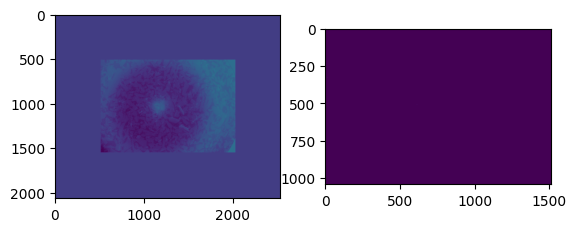

  0%|          | 1/2217 [00:08<5:15:58,  8.56s/it]

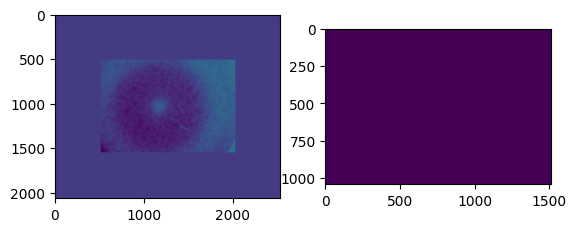

  0%|          | 2/2217 [00:15<4:37:03,  7.50s/it]

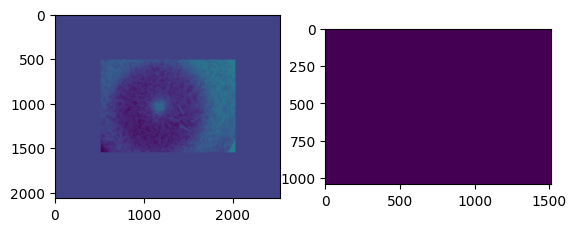

  0%|          | 3/2217 [00:22<4:25:01,  7.18s/it]

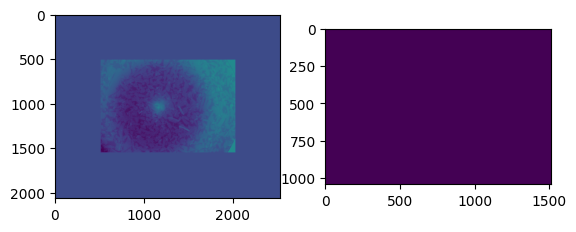

  0%|          | 0/1041 [00:00<?, ?it/s]

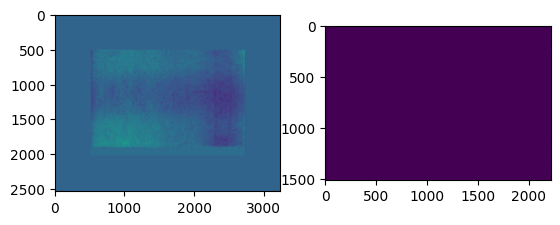

  0%|          | 1/1041 [00:06<1:57:24,  6.77s/it]

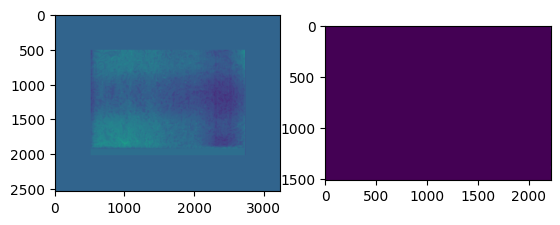

  0%|          | 2/1041 [00:13<1:54:50,  6.63s/it]

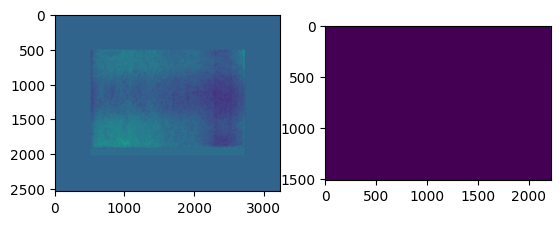

  0%|          | 3/1041 [00:19<1:54:36,  6.63s/it]

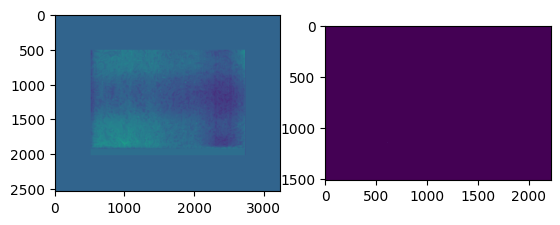

  0%|          | 0/1511 [00:00<?, ?it/s]

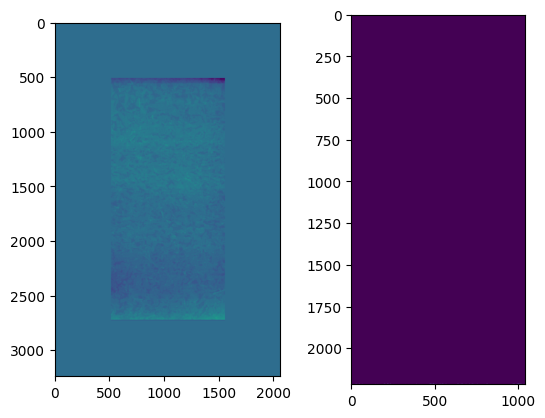

  0%|          | 1/1511 [00:09<3:58:56,  9.49s/it]

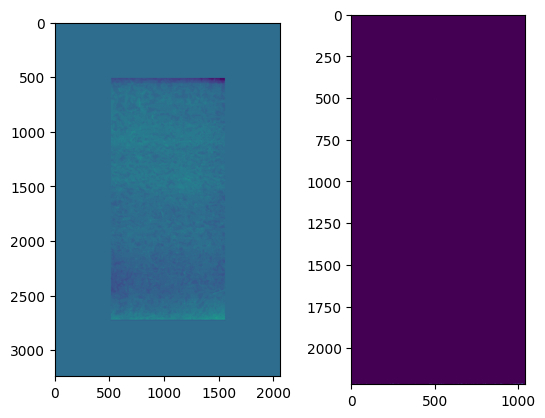

  0%|          | 2/1511 [00:15<3:02:27,  7.25s/it]

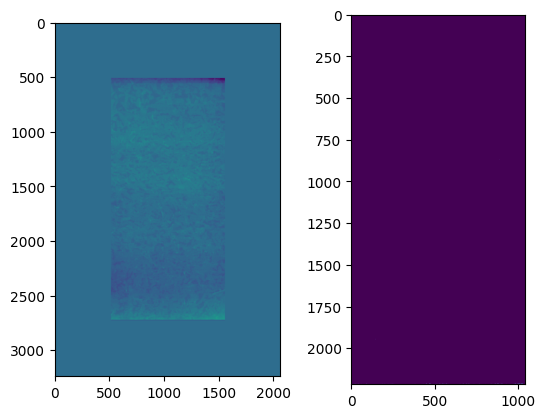

  0%|          | 3/1511 [00:20<2:44:41,  6.55s/it]

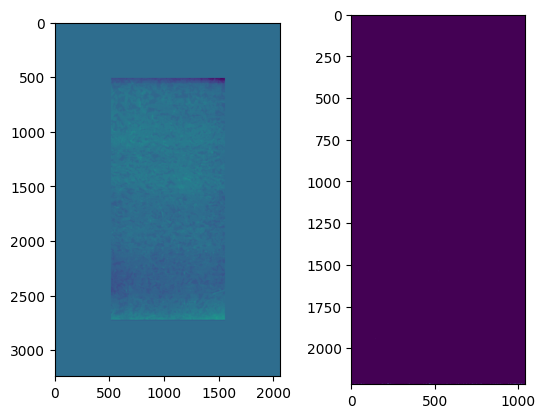

  0%|          | 3/1511 [00:27<3:48:38,  9.10s/it]


0


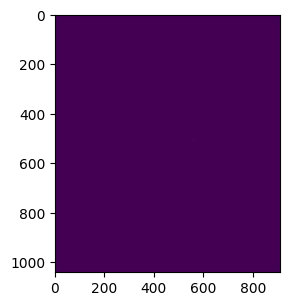

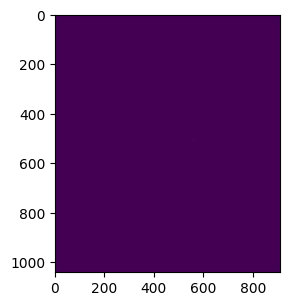

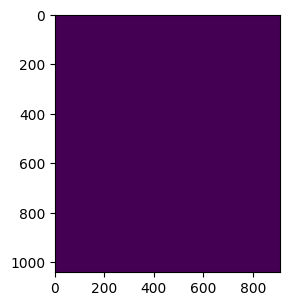

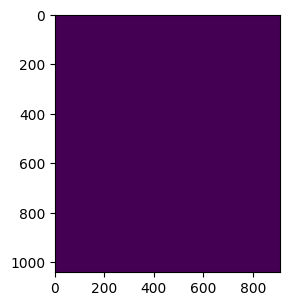

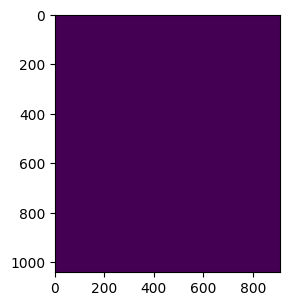

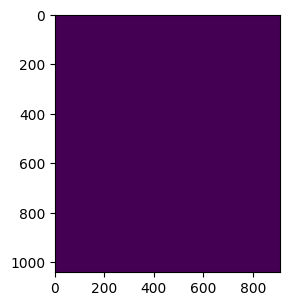

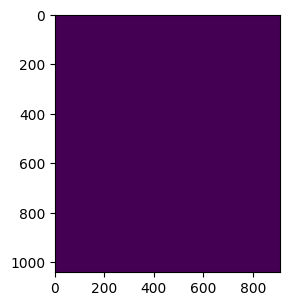

,id,rle
0,kidney_2_0000,466591 1
0,kidney_2_0001,466591 1
0,kidney_2_0002,1 0
0,kidney_2_0003,1 0
0,kidney_2_0004,1 0
0,kidney_2_0005,1 0


In [9]:
# Check if it's for submission based on the presence of test images
is_submit = len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif")) != 3

# Get segmentation output and associated ids
output, ids = get_output(not is_submit)

# Calculate threshold for binary predictions
TH = [x.flatten().numpy() for x in output]
TH = np.concatenate(TH)
index = -int(len(TH) * CFG.th_percentile)
TH: int = np.partition(TH, index)[index]
print(TH)

# Read an example image for visualization
img = cv2.imread("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0001.tif", cv2.IMREAD_GRAYSCALE)

# Initialize a list for submission dataframe
submission_df = []
debug_count = 0

# Loop through each prediction and generate RLE encoding
for index in range(len(ids)):
    id = ids[index]
    i = 0

    # Find the corresponding output based on the index
    for x in output:
        if index >= len(x):
            index -= len(x)
            i += 1
        else:
            break

    # Extract the binary mask based on the threshold
    mask_pred = (output[i][index] > TH).numpy()

    # Convert the binary mask to the original size
    mask_pred2 = to_original(mask_pred, img, image_size=1024)
    mask_pred = mask_pred2.copy()

    # Visualization (if not for submission)
    if not is_submit:
        plt.subplot(121)
        plt.imshow(mask_pred)
        plt.show()
        debug_count += 1
        if debug_count > 6:
            break

    # Encode the binary mask using Run-Length Encoding
    rle = rle_encode(mask_pred)

    # Append information to the submission dataframe
    submission_df.append(
        pd.DataFrame(data={
            'id': id,
            'rle': rle,
        }, index=[0])
    )

# Concatenate the submission dataframes and save to a CSV file
submission_df = pd.concat(submission_df)
submission_df.to_csv('submission.csv', index=False)
submission_df.head(6)
